Ce notebook n°2 fait suite au notebook n°1 ayant généré des résumés et du NER.
Le fichier de départ est limité à 500 records.
Le fichier (structure CSV) se nomme "**enron_unique_output_0_499.csv**"

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/"
file_name = "enron_unique_output_0_499.csv"
file = file_path+file_name

df_emails = pd.read_csv(file)
df_emails.tail(10)
deb = 0
fin = df_emails.shape[0]

In [29]:
deb,fin

(0, 500)

In [ ]:
# SAUVEGARDE en csv du résultat.
def svgd_csv_xls (file_path,file_name):

# to .CSV
  file_extension = ".csv"
  file = file_path+file_name+file_extension
  print("File : ",file)
  df_emails.to_csv(file, encoding='utf-8', index=False)
# df_emails[deb:fin].to_csv(file, encoding='utf-8', index=False)
  print("Svgde effectuée")
  return


# DataCleaning Improvements

In [ ]:
df_emails['body_clean2'] = ''

def data_clean_fw (data):
  data = data.lower()
  if 'forwarded by' in data:
    if 'subject:' in data:
      data = data.split('subject:')[1]
      data = data.strip()
    return data

df_emails['body_clean2'] = df_emails['body_clean'].apply(data_clean_fw)
svgd_csv_xls (file_path,file_name)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/temp.csv
Svgde effectuée


In [ ]:
# suppression dans le corps du texte de tout ce qui precede la mention 'subject:" y compris le subject"
def data_clean_header_in_body(header,body):
  # Suppression de tout ce qui précède l'objet (inclus) dans le corps du mail
  # header = df_emails['header'][id]
  # body = df_emails['body_clean'][id]
  ref = 'Subject: '+str(header)+' '
  result = body.find(ref)
  if result != -1:
    result +=len(ref)
    texte = body[result:]
  else:
    texte = body
  # Traitement des mails avec header vide mais comportement Subject dans le body : on supprime tout ce qui précéde jusqu'à  subject
  ref = 'Subject: '
  result = body.find(ref)
  if result != -1:
    result +=len(ref)
    texte = body[result:]
  else:
    texte = body
  return texte


In [ ]:
deb = 0
fin = df_emails.shape[0]


print("DataCleaning 2/2 en cours pour ",fin, "records.")
for id in range(deb,fin):
  print('ID:',id)
# step 1 : suppression de tous les caractères parasites
#  df_emails['body_clean'][id] = data_clean(str(df_emails['body'][id]))
# step 2 : Suppression de tout ce qui précède l'objet (inclus) dans le corps du mail
  try:
    header = df_emails['header'][id]
    body = df_emails['body_clean'][id]
    df_emails['body_clean'][id] = data_clean_header_in_body(header,body)
  except:
    print('erreur retraitement body ID',id)
print("DataCleaning terminé pour ",fin, "records.")

file_name = "temp"
svgd_csv_xls (file_path,file_name)

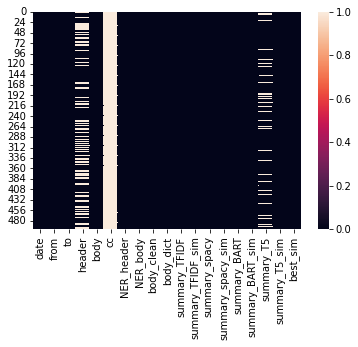

In [ ]:
# voir les champs qui comportent des valeurs nulles
import seaborn as sns
sns.heatmap(df_emails.isna())

# Vectorization with TF-IDF Vectorizer

In [77]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords

data = df_emails['body_clean']

#tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',max_features = 20000, decode_error='ignore')
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english', max_features=None ,decode_error='ignore')
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)

tf_idf_array = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names_out()).head()


tf_idf_dtm = pd.DataFrame(tf_idf_norm.toarray(), columns=tf_idf_vectorizor.get_feature_names_out()).head()
tf_idf_dtm


,00,000,000000000000935,000000000001282,000000000021442,000119,0009,000mmbtu,001,0010,...,zeitz,ziegelaar,zimin,zisman,zivic,zone,zoning,zub,zufferli,zuniga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


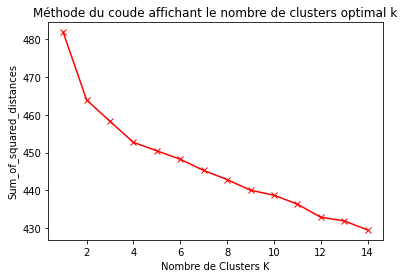

In [109]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=0)
   km = km.fit(tf_idf)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'rx-')
plt.xlabel('Nombre de Clusters K')
plt.ylabel('Sum_of_squared_distances')
plt.title('Méthode du coude affichant le nombre de clusters optimal k')
plt.show()

In [117]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(tf_idf)
labels=model.labels_
#
df_emails["labels"]=pd.Series(labels)
df_emails["labels"].value_counts()


3    316
0     83
2     69
1     32
Name: labels, dtype: int64

In [122]:
df_emails[labels==1]['NER_header'].value_counts()

()                                                        19
(Steve Kean,)                                              4
(4,)                                                       2
(nan,)                                                     1
(Access Request,)                                          1
(Enron Center Garage,)                                     1
(Enron Response, San Diego Request for Gas Price Caps)     1
(CERA Analysis - California,)                              1
(California Gas Demand Growth,)                            1
(ONLY 500, MW)                                             1
Name: NER_header, dtype: int64

In [91]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               500 non-null    object 
 1   from               500 non-null    object 
 2   to                 500 non-null    object 
 3   header             339 non-null    object 
 4   body               500 non-null    object 
 5   cc                 0 non-null      float64
 6   NER_header         500 non-null    object 
 7   NER_body           500 non-null    object 
 8   body_clean         500 non-null    object 
 9   body_dict          500 non-null    object 
 10  summary_TFIDF      500 non-null    object 
 11  summary_TFIDF_sim  500 non-null    float64
 12  summary_spacy      500 non-null    object 
 13  summary_spacy_sim  500 non-null    float64
 14  summary_BART       500 non-null    object 
 15  summary_BART_sim   500 non-null    float64
 16  summary_T5         428 non

In [116]:
df_emails[labels==3][["labels","NER_header","NER_body","header","summary_TFIDF"]].sample(20)

,labels,NER_header,NER_body,header,summary_TFIDF
429,3,(),"(2,)",Re:,The west desk would like 2 analysts.
439,3,(),(),Re:,no. I am on msn messenger.
222,3,"(27,)","(ac, 27, August through ,, December, 713)",RE: a/c for #27,"Go ahead and order the ac for #27. , Can you ..."
147,3,(),"(gary,)",Re: market intelligence,"gary , thanks for the info."
247,3,"(228,204,)",(),"Re: APEA - $228,204 hit",is this still an issue?
62,3,"(nan,)","(Jean Mrha, tomorrow)",NaN,"Ina , I scheduled a meeting with Jean Mrha to..."
421,3,(),(),Re:,yes please
420,3,(),(),Re: General Issues,"That would we very helpful. Thanks , Phillip"
412,3,(),"(Tomorrow,)",Re: Weekly Status Meeting,"Tomorrow is fine. Talk to you then , Phillip"
115,3,"(Resume - Rafael Avila,)","(Karen Buckley, May)",Re: Analyst Resume - Rafael Avila,Send to Karen Buckley. Trading track intervie...


In [ ]:
# Svgd version intermédiaire
#  if int(id/100) == id/100:
#    file_name_tmp = "Phase 2 - enron_unique_output_"+str(id)
#    file = file_path+file_name_tmp
#    svgd_csv_xls (file_path,file_name_tmp)
#    print(file_name_tmp," sauvegardé.")



In [ ]:
svgd_csv_xls (file_path,file_name)

File :  /content/drive/MyDrive/Datascientest/Projet PY_email Datascientest/Data/Enron Cleaned Data/temp.csv
Svgde effectuée


# Bibliographie ou References

In [ ]:
# https://medium.com/towards-data-science/k-means-clustering-8e1e64c1561c
# a voir ? https://www.kaggle.com/code/dfoly1/k-means-clustering-from-scratch/notebook
# https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z
# https://www.kaggle.com/code/dikshabhati2002/nlp-for-beginners
# https://www.kaggle.com/code/ashagutlapalli/nlp-101-with-nltk-and-spacy-text-analysis
# https://www.kaggle.com/code/liruffel/atelier-nlp/notebook